# Deep portfolio Optimization

Portfolio optimization appears from our point of view as a special case of deep hedging. Again we give ourselves a market environment in terms of a certain number of price evolutions (they constitute the training data) and preferences in terms of expected utility. Instead of solving the more complicated task of obtaining an indifference price for a payoff at time $T$ we do just go for an optimal portfolio maximizing our preferences. This is a very classical task of financial theory with a couple of caveats:

1) We need preferences to solve this problem, i.e. expected utility in our case
   $$
    X \mapsto E[u(X)] \, .
   $$
   Notice that by Jensen's inequality we have that $ E[u(x+X)] \leq u \big( x +E[X] \big) $, which means that    
   we only invest into $X$ if it has positive return.

2) Whence we need the return of the market in contrast to Deep hedging where we can also caculate with 
   respect to measures different from the statistical measure. Notice that the statistical measure is 
   impossible to determine with short time series even under stationarity assumptions.
    
3) Also preferences themselves are not given by nature but subjectively and not necessarily time-consistently  determined. Also here an ad hoc assumption appears.

Given all the necessary ingredients for deep hedging we can move forward and solve the problem in the particular case, similar to before, where the market is given by a Black-Merton-Scholes model. Of course the core code to solve the problem does not depend on the training data.

Consider an investor who invests at any time a proportion $\alpha$ of her wealth in a stock and the proportion $1-\alpha$ in the bond. We suppose that the bond price grows at the constant interest rate $r$, i.e. 

$$
dB_t=r B_t dt,
$$

and the stock price evolves according to the Black-Scholes model:

$$
dS_t=S_t\mu dt + S_t \sigma dW_t.
$$

Prove first that the nonnegative wealth process $X$ controlled by the proportion $(\alpha_t)_{t \geq 0}$ with values in $\mathbb{R}$, invested in the stock is governed by the following diffusion dynamics :

$$
dX_t= \alpha_t X_t  \frac{dS_t}{S_t} + (1-\alpha_t) X_t r_t dt.
$$

The objective is to maximize over the portfolio strategy $(\alpha_t)$ the expected utility 
of terminal wealth at time $T=1$, i.e.

$$
\max_{\alpha} \mathbb{E}_{P}[u(X_1)].
$$

Take as utility function the CRRA (Constant Relative Risk Aversion) function $u(x)=\frac{x^{\gamma}-1}{\gamma}$ with $0<\gamma <1$ and $ u(x) = \log(x) $ for $ \gamma = 0 $. These are typical utility functions defined on $ \mathbb{R}_{\geq 0} $ with risk aversion parameter $ \gamma $.
Start with initial wealth of $X_0=1$, take $\mu=0.1$, $r=0.05$ and $\sigma=0.2$, discretize the SDE for $X$ and try to find an optimal proportion $\alpha$ by parametrizing $\alpha$ as a neural network depending on the current price. How does $\alpha$ depend on the choice of $\gamma$? This is the classical question of the Merton problem solved by Robert Merton in March 1970, so precisely 50 years ago, in the famous paper [Optimum Consumption Rules in a Continuous-time model](https://dspace.mit.edu/bitstream/handle/1721.1/63980/optimumconsumpti00mert.pdf;jsessionid=210961A5E3789DD3A9D1D7C7ACDA6CC2?sequence=1).

Actually there a more general problem is solved: the strategy is optimized among all possible predictable strategies but it turns out due to the homogeneities of the model that the ratio is actually constant, then the calculation is indeed quite simple: we have to optimize
$$
\alpha \mapsto E\Big[\exp \big( \gamma(\alpha \sigma B_t - \frac{-\alpha\mu + \alpha^2\sigma^2}{2}t + (1-\alpha)rt \big) \Big] \,
$$
whose first order condition leads to
$$
E\Big[\exp \big( \gamma(\alpha \sigma B_T - \frac{- 2 \alpha\mu + \alpha^2\sigma^2}{2}T + (1-\alpha)rT \big) \big(\sigma B_T + \alpha \sigma^2 T + \mu T - rT \big)\Big] = 0 \, .
$$
This can be solved by actually expanding for small $T$ and collecting orders up to $ T $, indeed
$$
E\Big[ \big( 1 + \gamma(\alpha \sigma B_T + \frac{\alpha^2\sigma^2\gamma}{2}B_T^2 - \frac{-2 \alpha\mu + \alpha^2\sigma^2}{2}T + (1-\alpha)rT \big) \big(\sigma B_T - \alpha \sigma^2 T + \mu T - rT \big)\Big] = 0 \, .
$$
There is obviously no order $0$ term in $T$, there is an order $ \sqrt{T} $ term proportional to $ E[B_T] $ which vanishes, whence we are left with the order $ T $, which reads
$$
 -\alpha \sigma^2  + \mu  - r + \gamma \alpha \sigma^2 = 0
$$
and leads to the result $ \alpha^* = \frac{\mu - r}{\sigma^2(1-\gamma)} $.If the above calculation is done with enough care, one can also see the result that a predictable strategy actually has to be constant in time and factors.

In [1]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards

N=30 # time disrectization
S0=1 # initial value of the asset
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
mu=0.1
r=0.0
gamma=0.0
R=10**5 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

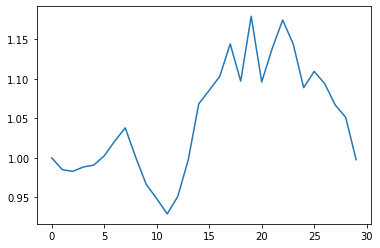

In [3]:
for i in range(1):
   plt.plot(S[:,i])
plt.show()

In [5]:
logX= np.zeros((N,R))
logX[0,]=np.log(X0)*np.ones((1,R))
alpha= (mu-r)/(sigma**2*(1-gamma))
for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
        logX[j+1,i] =logX[j,i]+increment*alpha+r*T/N*(1-alpha)-alpha**2*sigma**2*T/(2*N)

X=np.exp(logX)
loss=np.mean(-np.log(X[N-1,:]))# np.mean(-(W[N-1,:]**gamma))
print(loss)

-0.12050318258584651


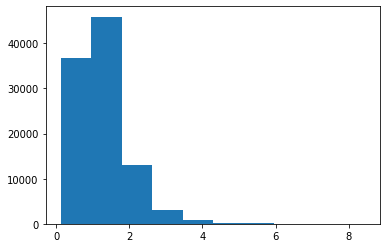

1.2717172805369048
0.6629167694417964


In [6]:
plt.hist(X[N-1,:])
plt.show()
print(np.mean(X[N-1,:]))
print(np.std(X[N-1,:]))

In [7]:
#Definition of neural networks for trading strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [8]:
# Implementing the outcoming of trading via neural networks
# Inputs is the training set below, containing the price S0, 
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
trade = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))

inputs = [price]+[trade]+[tradeeval]+[wealth]
outputhelper=[]

for j in range(N):
    strategy = price
    strategyeval=tradeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j 
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew
    logwealth= Lambda(lambda x : K.log(x))(wealth)
    logwealth= Lambda(lambda x : x+r*T/N)(logwealth)
    helper1 = Multiply()([strategy, incr])
    #helper1 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    logwealth = Add()([logwealth, helper1])
    helper2 = Multiply()([strategy, strategy])
    #helper2 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    helper3 = Lambda(lambda x : x*sigma**2/2*T/N)(helper2)
    logwealth = Subtract()([logwealth, helper3])
    helper4 = Lambda(lambda x : x*r*T/N)(strategy)
    logwealth = Subtract()([logwealth, helper4])
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval] # here we collect the strategies
    wealth=wealthnew
outputs = wealth
randomendowment = Lambda(lambda x : -0.0*(K.abs(x-1.0)+x-1.0))(price) 
outputs = Add()([wealth,randomendowment])
outputs = [outputs] + outputhelper 
outputs = Concatenate()(outputs)

model_Merton = Model(inputs=inputs, outputs=outputs)

In [10]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0
# xtrain consists of the price S0, 
#the initial hedging being 0, and dummy variables hedgeeval where the strategies are evaluated, 
#the initial wealth and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,m))] +
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [11]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])#-((y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z

In [12]:
from keras import optimizers

adam=optimizers.Adam(lr=0.01)

model_Merton.compile(optimizer='adam',loss=custom_loss)

In [13]:
import matplotlib.pyplot as plt

for i in range(1):
    model_Merton.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
100000/100000 [==============================] - 21s 213us/step - loss: -0.1186
Epoch 2/10
100000/100000 [==============================] - 15s 148us/step - loss: -0.1215
Epoch 3/10
100000/100000 [==============================] - 15s 149us/step - loss: -0.1218
Epoch 4/10
100000/100000 [==============================] - 15s 148us/step - loss: -0.1223
Epoch 5/10
100000/100000 [==============================] - 15s 149us/step - loss: -0.1224
Epoch 6/10
100000/100000 [==============================] - 15s 149us/step - loss: -0.1227
Epoch 7/10
100000/100000 [==============================] - 15s 150us/step - loss: -0.1228
Epoch 8/10
100000/100000 [==============================] - 15s 151us/step - loss: -0.1229
Epoch 9/10
100000/100000 [==============================] - 15s 149us/step - loss: -0.1229
Epoch 10/10
100000/100000 [==============================] - 15s 148us/step - loss: -0.1230


In [14]:
y_pred = model_Merton.predict(xtrain)
print(np.mean(-np.log(y_pred[:,0])))

-0.12318956


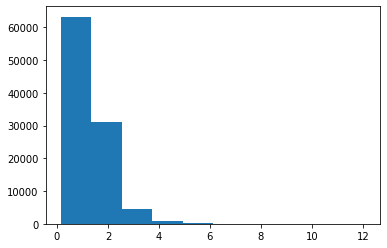

1.2898568
0.7102659


In [15]:
plt.hist(model_Merton.predict(xtrain)[:,0])
plt.show()
print(np.mean(model_Merton.predict(xtrain)[:,0]))
print(np.std(model_Merton.predict(xtrain)[:,0]))

In [16]:
k=10#Choose a number between 1 and N-1
Ktest=60
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.7,1.5,Ktest)] +#change this if you go to higher dimensions
          [initialwealth*np.ones((Ktest,m))]+
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])


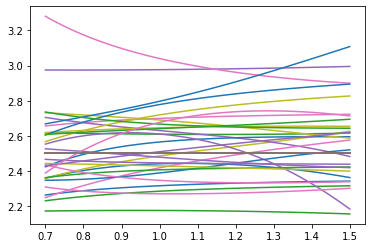

2.4999999999999996


In [17]:
#Comparison of learned and true alpha
s=np.linspace(0.7,1.5,Ktest)

for k in range(1,N):
    truestrat=(mu-r)/(sigma**2*(1-gamma))*np.ones(Ktest)
    learnedstrat=model_Merton.predict(xtest)[:,k]
    plt.plot(s,learnedstrat,s,truestrat)
plt.show()
print((mu-r)/(sigma**2*(1-gamma)))